<a href="https://colab.research.google.com/github/ziatdinovmax/Notebooks-for-papers/blob/master/ferroics-causal-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Causal analysis of competing atomistic mechanisms in ferroelectric materials from high-resolution Scanning Transmission Electron Microscopy data

Prepared by Maxim Ziatdinov (January 2020)

Email: maxim.ziatdinov@ai4microscopy.com

This notebook loads scanning transmission electron microscopy image data from ferroic material (Sm-doped BFO) with the associated unit cell parameters for each image and performs pairwise causal analysis on these parameters.

Download data:

In [1]:
%%shell
gdown -q https://drive.google.com/uc?id=1PwaddcnZoXr_o2K_RTsVM1Uky8ov7yNT
unzip -q ferroic_data.zip
ls ferroic_data

01_site1_22_23_HAADF.h5		      03_site7_55_56_UCParameterization.h5
01_site1_22_23_UCParameterization.h5  07_site5_32_33_HAADF.h5
03_site7_55_56_HAADF.h5		      07_site5_32_33_UCParameterization.h5


Imports:

In [0]:
import os
import pandas as pd
import h5py
try:
    import pyro
except ModuleNotFoundError:
    !pip install -q pyro-ppl==1.1.0
    import pyro
import pyro.contrib.gp as gp
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pyro.set_rng_seed(0)
torch.random.manual_seed(0);

Select files for one of the compositions and view the corresponding image and available UC parameters:

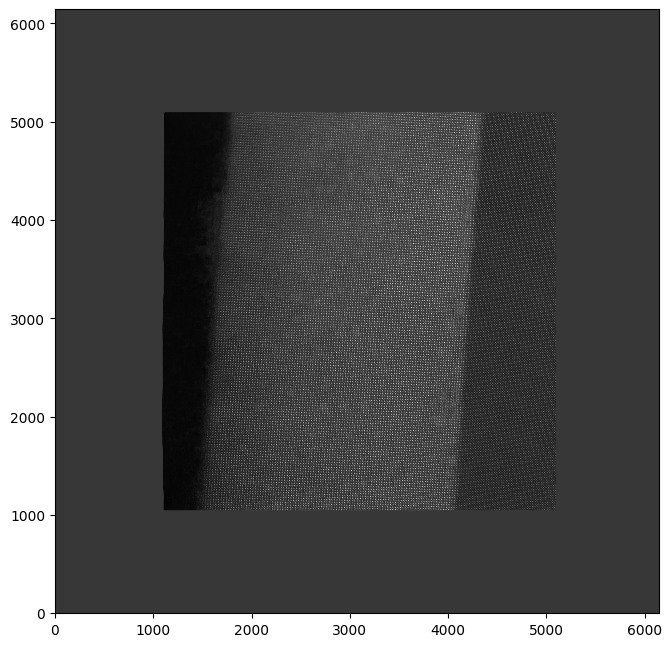

UC parameterization: ['I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'adelta', 'alpha', 'atmindex', 'b', 'bdelta', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms']


In [3]:
filedir = 'ferroic_data'
img_filename = '01_site1_22_23_HAADF.h5' # image
UCparam_filename = '01_site1_22_23_UCParameterization.h5' # unit cell params

img = h5py.File(os.path.join(filedir, img_filename), 'r')
UCparam = h5py.File(os.path.join(filedir, UCparam_filename), 'r')
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(img['MainImage'], origin='bottom', cmap='gray')
plt.show()
print('UC parameterization:', [k for k in UCparam.keys()])

We can view x and y polarization components:

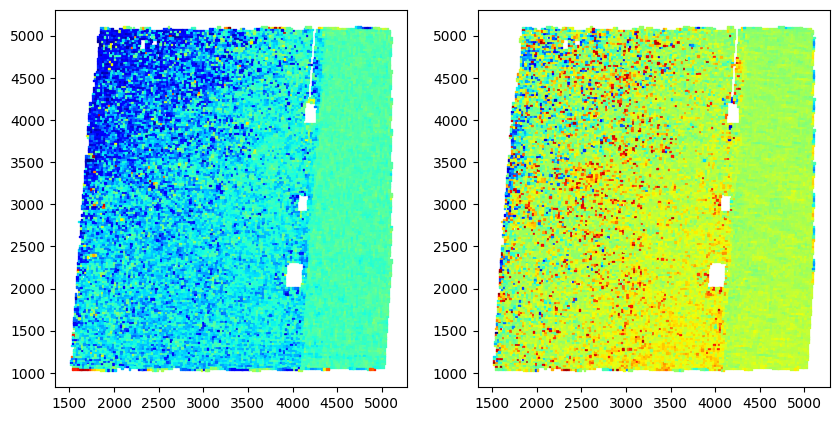

In [4]:
xy_COM = UCparam['xy_COM'][()].T
Pxy = UCparam['Pxy'][()].T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax1.scatter(xy_COM[:, 1], xy_COM[:, 0], c=Pxy[:, 0], marker='s', s=1, cmap='jet')
ax2.scatter(xy_COM[:, 1], xy_COM[:, 0], c=Pxy[:, 1], marker='s', s=1, cmap='jet');

Here plot joint distribution for the selected variables:

<Figure size 576x576 with 0 Axes>

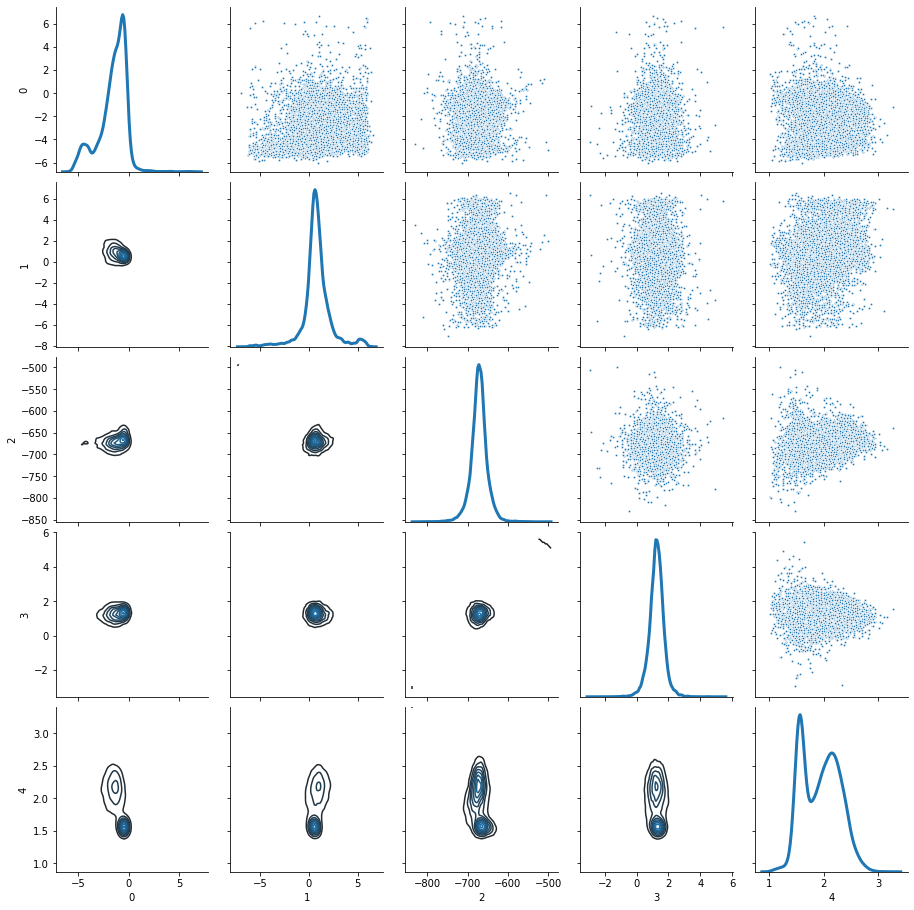

In [5]:
# Specify variables you want to plot here
cols = [
         UCparam['Pxy'][()][0, :],
         UCparam['Pxy'][()][1, :],
         UCparam['Vol'][()][0, :], 
         UCparam['b'][()][0, :],
         UCparam['I5'][()][0, :],
         # you can add more variables to the list
]

cols = np.array(cols)
cols = pd.DataFrame(cols.T)
plt.figure(figsize=(8, 8))
g = sns.PairGrid(cols, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot, s=7)
g.map_diag(sns.kdeplot, lw=3)

We next define helper functions for the geometric and additive noise causal inference. For details, see *J. M. Mooij, J. Peters, D. Janzing, J. Zscheischler, and B. Scholkopf. Distinguishing cause from effect using observational data: methods and benchmarks. Journal of Machine Learning Research, 17:1–102, 2016.*

In [0]:
def igci_estimator(x, y, scale=True):
    """
    Determines causal direction between two 1D variables
    using slope-based information-geometric causal inference.
    
    Args:
        x: 1D numpy array:
            Observed x-values
        y: 1D numpy array
            observed y-values
        scale: bool
            Standardization of x and y
    
    Return:
        Value of C_{x->y} - C_{y->x}. 
        If the value < 0, x causes y (x->y).
        If the value > 0, y causes x (x<-y).
    """
    if scale:
        x = (x - np.mean(x)) / np.std(x)
        y = (y - np.mean(y)) / np.std(y)
    a1, a2 = 0, 0
    x_ix, y_ix = x[np.argsort(x)], y[np.argsort(x)]
    x_iy, y_iy =  x[np.argsort(y)], y[np.argsort(y)] 
    for x1, x2, y1, y2 in zip(x_ix[:-1], x_ix[1:], y_ix[:-1], y_ix[1:]):
        if all([x1 != x2, y1 != y2]):
            a1 += np.log(np.abs((y2 - y1) / (x2 - x1)))
    for x1, x2, y1, y2 in zip(x_iy[:-1], x_iy[1:], y_iy[:-1], y_iy[1:]):
        if all([x1 != x2, y1 != y2]):
            a2 +=  np.log(np.abs((x2 - x1) / (y2 - y1)))
    return (a1 - a2) / len(x)


def res_estimator(x, y, scale=True, regressor='gp'):
    """
    Calculates causality direction using regression fit 
    with a subsequent independence of residuals test.
    The so-called additive noise model (ANM).

    Args:
        x: 1D numpy array:
            Observed x-values
        y: 1D numpy array
            observed y-values
        scale: bool
            Standardization of x and y
    
    Return:
        Value of C_{x->y} - C_{y->x}. 
        If the value < 0, x causes y (x->y).
        If the value > 0, y causes x (x<-y).
    """
    if scale or regressor == 'nn':
        x = (x - np.mean(x)) / np.std(x)
        y = (y - np.mean(y)) / np.std(y)
    return get_res_score(x, y, regressor) - get_res_score(y, x, regressor)

def get_res_score(x, y, regressor):
    """Regression with a subsequent independence of residuals test""" 
    if regressor == 'gp': 
        y_pred = GP_Regressor(x, y)
    elif regressor == 'nn':
        y_pred = NN_Regressor(x, y)
    else:
        raise NotImplementedError("Choose between 'nn' and 'gp'")
    return hsic_test(y_pred - y, x)

def GP_Regressor(X, y):
    """
    Performs exact gaussian process regression 
    for variable with < 2000 data points.
    Performs sparse gaussian process regression
    for variable with > 2000 points
    """
    pyro.clear_param_store()
    X = X[:, np.newaxis] if np.ndim(X) == 1 else X
    if torch.cuda.is_available():
        torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    else:
        torch.set_default_tensor_type(torch.DoubleTensor)
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        X, y = X.cuda(), y.cuda()
    if len(X) < 2000:
        gpr = gp.models.GPRegression(
            X, y, gp.kernels.RBF(input_dim=1))
    else:
        indp_step = int(1e-3 * len(X))
        gpr = gp.models.SparseGPRegression(
            X, y, 
            gp.kernels.RBF(input_dim=1), 
            Xu=torch.tensor(X[::indp_step]), 
            jitter=1e-3) # we increase jitter when working with non-standardized data
    if torch.cuda.is_available():
        gpr.cuda()
    optimizer = torch.optim.Adam(gpr.parameters(), lr=5e-2)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    for _ in range(250):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        mean, _ = gpr(X, full_cov=False, noiseless=False)
    return mean.cpu().numpy()

def NN_Regressor(X, y):
    """
    Performs a neural network-based regression.
    Neural network has two fully connected layers
    with 100 neurons each. 
    """
    X = X[:, np.newaxis] if np.ndim(X) == 1 else X
    y = y[:, np.newaxis] if np.ndim(y) == 1 else y
    if torch.cuda.is_available():
        torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    else:
        torch.set_default_tensor_type(torch.DoubleTensor)
    X = torch.from_numpy(X)
    y = torch.from_numpy(y) 
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        X, y = X.cuda(), y.cuda()
    model = torch.nn.Sequential(
        torch.nn.Linear(in_features=1, out_features=100),
        torch.nn.SELU(),
        torch.nn.Linear(in_features=100, out_features=100),
        torch.nn.SELU(),
        torch.nn.Linear(in_features=100, out_features=1),
    )
    if torch.cuda.is_available():
        model.cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.MSELoss()
    for e in range(1000):
        optimizer.zero_grad()
        y_predicted = model(X)
        loss = criterion(y_predicted, y)
        loss.backward()
        optimizer.step() 
    return y_predicted.detach().cpu().numpy()[:, 0]

def hsic_test(X, Y):
    """
    The HSIC independence test.
    For variable with > 2000 datapoints uses every 5th datapoint
    """ 
    X = X[:, np.newaxis] if np.ndim(X) == 1 else X
    Y = Y[:, np.newaxis] if np.ndim(Y) == 1 else Y
    s = 1 if len(X) < 2000 else 5
    n = X[::s].shape[0]
    width_x = estimate_sigma(X[::s])
    width_y = estimate_sigma(Y[::s])
    H = np.identity(n) - np.ones((n,n), dtype=float) / n
    K = rbf_kernel(X[::s], X[::s], width_x)
    L = rbf_kernel(Y[::s], Y[::s], width_y)
    Kc = np.dot(np.dot(H, K), H)
    Lc = np.dot(np.dot(H, L), H)
    return np.sum(Kc.T * Lc) / n

def rbf_kernel(X1, X2, deg):
    """Constructs rbf kernel matrix""" 
    G = np.sum(X1*X1, axis=1)[:, np.newaxis]
    H = np.sum(X2*X2, axis=1)[:, np.newaxis]
    Q = np.tile(G, (1, X2.shape[0]))
    R = np.tile(H.T, (X1.shape[0], 1))
    K = Q + R - 2* np.dot(X1, X2.T)
    return np.exp(-K / (2 * deg**2))

def estimate_sigma(X):
    """Sets kernel width to median distance between points"""
    G = np.sum(X*X, axis=1)[:, np.newaxis]
    Q = np.tile(G, (1, X.shape[0]) )
    dists = Q + Q.T - 2* np.dot(X, X.T)
    dists = dists - np.tril(dists)
    dists = dists.flatten()
    return np.sqrt(0.5 * np.median(dists[dists > 0]))

def remove_edge_points(feature, coordinates, dist_edge):
        
    def coord_edges(coord, coordinates, dist_edge):
        return [coord[0] > np.amax(coordinates[:, 0]) - dist_edge,
                coord[0] < np.amin(coordinates[:, 0]) + dist_edge,
                coord[1] > np.amax(coordinates[:, 1]) - dist_edge,
                coord[1] < np.amin(coordinates[:, 1]) + dist_edge]

    idx_to_rem = [
                  idx for idx, c in enumerate(coordinates)
                  if any(coord_edges(c, coordinates, dist_edge))
                  ]
    feature = np.delete(feature, idx_to_rem, axis=0)
    return feature

Finally, we run causal inference for the selected pairs of variables. For the ANM models, each pair will take ~5 min (it is faster with 'nn' than with 'gp' regressor option).


(To run the exact same causal inference models on the labeled cause-effect pairs use [this notebook](https://colab.research.google.com/drive/1ZRDFI8bhhY2AH6lSw1Dg9fm0RwQ9IK_7))

In [8]:
# Specify variables you want to analyze for cause-effect relationships
X_all = [UCparam['Pxy'][()][0, :],
         UCparam['Pxy'][()][1, :],
         UCparam['Vol'][()][0, :], 
         UCparam['a'][()][0, :] / UCparam['b'][()][0, :],
         UCparam['I1'][()][0, :],
         UCparam['I5'][()][0, :], 
         # you can add more variables to the list
]

# remove edge points (optionally; no points are removed by default)
rmep = lambda d: remove_edge_points(d, UCparam['xy_COM'][()].T, 0)
X_all = [rmep(x) for x in X_all]
# Choose whether to standardize data, (X - np.mean(X)) / np.std(X)
# (automatically sets to True when regressor if ANM model is a neural network)
scale = False
# Choose regressor for ANM analysis ('nn' or 'gp')
regressor = 'gp'
# helper func for printing intermediate results
def print_results(output, i1, i2):
    if output !=0:
        print(output)
        s = [i1, i2] if output < 0 else [i2, i1]
        print('Causal direction {}-->{}'.format(s[0], s[1]))
    else:
        print('No causal relationship established')

# Run analysis        
caus_mat1 = np.zeros(shape=(len(X_all), len(X_all)))
caus_mat2 = np.zeros(shape=(len(X_all), len(X_all)))
for i1, val1 in enumerate(X_all):
    for i2, val2 in enumerate(X_all):
        if i1 != i2:
            print("\nAnalyzing {}-{} pair...".format(i1, i2))
            output = igci_estimator(val1, val2, scale)
            caus_mat1[i1, i2] = output
            print('ICGI prediction:')
            print_results(output, i1, i2)
            output = res_estimator(val1, val2, scale, regressor)
            caus_mat2[i1, i2] = output
            print('ANM prediction:')
            print_results(output, i1, i2)


Analyzing 0-1 pair...
ICGI prediction:
-0.0016859278735870784
Causal direction 0-->1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ANM prediction:
20.756769873604885
Causal direction 1-->0

Analyzing 0-2 pair...
ICGI prediction:
5.608130970367455
Causal direction 2-->0
ANM prediction:
-0.9725454542906284
Causal direction 0-->2

Analyzing 0-3 pair...
ICGI prediction:
4.006017004522657
Causal direction 3-->0
ANM prediction:
5.535456639212827
Causal direction 3-->0

Analyzing 0-4 pair...
ICGI prediction:
6.472944293297705
Causal direction 4-->0
ANM prediction:
-7.77681392177438
Causal direction 0-->4

Analyzing 0-5 pair...
ICGI prediction:
-2.6050984144770637
Causal direction 0-->5
ANM prediction:
1.019158489910735
Causal direction 5-->0

Analyzing 1-0 pair...
ICGI prediction:
0.0016859278735870784
Causal direction 0-->1
ANM prediction:
-20.756769873604885
Causal direction 1-->0

Analyzing 1-2 pair...
ICGI prediction:
5.624525758597115
Causal direction 2-->1
ANM prediction:
-0.43641783678603474
Causal direction 1-->2

Analyzing 1-3 pair...
ICGI prediction:
4.030716779448583
Causal direction 3-->1
ANM prediction:
10.7

Plot results:

(Here, positive $C[row, column]$ means *column_variable --> row_variable* causal link, while negative $C[row, column]$ means *row_variable--> column_variable* causal link)

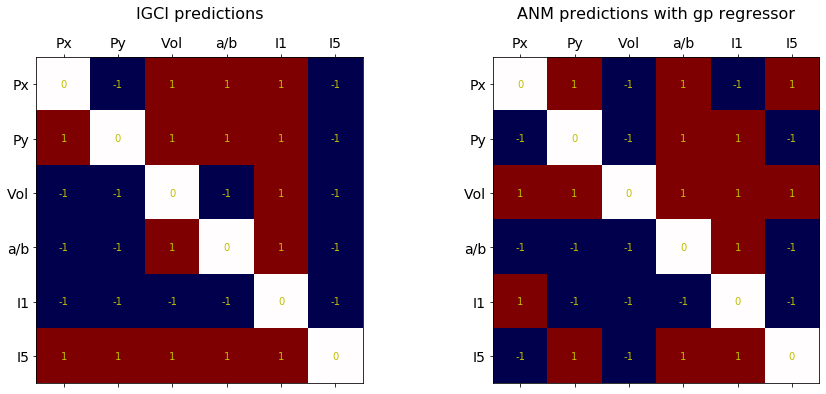

In [9]:
# optional
labels = ['Px','Py', 'Vol', 'a/b', 'I1', 'I5']

# IGCI model
caus_mat1[caus_mat1>0] = 1 # y --> x
caus_mat1[caus_mat1<0] = -1 # x --> y
_, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].matshow(caus_mat1, cmap='seismic')
for (j,i),output in np.ndenumerate(caus_mat1):
    ax[0].text(i,j,  int(output), ha='center', va='center', c='y')
ax[0].set_xticks(np.arange(caus_mat1.shape[0]))
ax[0].set_yticks(np.arange(caus_mat1.shape[1]))
if 'labels' in locals() and len(labels) > 0:
    ax[0].set_xticklabels(labels, rotation='horizontal', fontsize=14)
    ax[0].set_yticklabels(labels, rotation='horizontal', fontsize=14)
ax[0].set_title('IGCI predictions', y=1.1, fontsize=16)
# ANM model
caus_mat2[caus_mat2>0] = 1 # y --> x
caus_mat2[caus_mat2<0] = -1 # x --> y
ax[1].matshow(caus_mat2, cmap='seismic')
for (j,i),output in np.ndenumerate(caus_mat2):
    ax[1].text(i,j,  int(output), ha='center', va='center', c='y')
ax[1].set_xticks(np.arange(caus_mat2.shape[0]))
ax[1].set_yticks(np.arange(caus_mat2.shape[1]))
if 'labels' in locals() and len(labels) > 0:
    ax[1].set_xticklabels(labels, rotation='horizontal', fontsize=14)
    ax[1].set_yticklabels(labels, rotation='horizontal', fontsize=14)
ax[1].set_title('ANM predictions with {} regressor'.format(regressor),
                y=1.1, fontsize=16)
plt.show()

Get "causal sieve":

In [10]:
def get_hierarchy(caus_mat):
    dep_hier = [np.sum(row) for row in caus_mat]
    return np.argsort(np.array(dep_hier))
    
print(np.array(labels)[get_hierarchy(caus_mat1)])
print(np.array(labels)[get_hierarchy(caus_mat2)])

['I1' 'Vol' 'a/b' 'Px' 'Py' 'I5']
['a/b' 'I1' 'Py' 'Px' 'I5' 'Vol']
